<a href="https://colab.research.google.com/github/MinHyeok-lee1/AICamera/blob/master/REAL_FINAL_BETA_RAWvsScaled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
# 필요한 라이브러리 다운로드
# 버전이 바뀌었을때 발생할 수 있는 오류들을 경고해주는 메시지
import warnings
#warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
# System related and data input controls
import os
# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10
pd.options.display.max_columns = 20
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

import seaborn as sns

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from datetime import datetime
from pylab import rcParams
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima

# Model selection
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

In [173]:
# 1) Upload Data - Input Data
location = '/content/drive/MyDrive/Colab Notebooks/real_data.csv'
df = pd.read_csv(location, skiprows=1)

df=df.query('거래처계층그룹명 != "합계"')

df.rename(columns = {'일자' : 'Date'}, inplace = True)
df.rename(columns = {'수량' : 'counts'}, inplace = True)
df.rename(columns = {'거래처계층그룹명' : 'Ustore'}, inplace = True)
df.rename(columns = {'거래처코드' : 'store'}, inplace = True)
df.rename(columns = {'품목코드' : 'item'}, inplace = True)

# string 형태의 Date 필드를 datetime 형태로 변환
df['Date'] =  pd.to_datetime(df['Date'])

ARIMA_day = df.copy()

# date 필드를 index로 설정
ARIMA_day = ARIMA_day.set_index('Date')

# Xgboost용 data
Xgboost_Data = ARIMA_day.copy()

# Xgboost용 data, Xgboost 처리
swap1 = Xgboost_Data.Ustore.unique()
for i in range(swap1.size) :
  for j in range(Xgboost_Data.Ustore.size) :
    if(Xgboost_Data.Ustore[j] == swap1[i]): 
       Xgboost_Data.Ustore[j] = i+1
       continue

swap2 = Xgboost_Data.store.unique()
for i in range(swap2.size) :
  for j in range(Xgboost_Data.store.size) :
    if(Xgboost_Data.store[j] == swap2[i]): 
       Xgboost_Data.store[j] = i+1
       continue

swap3 = Xgboost_Data.item.unique()
for i in range(swap3.size) :
  for j in range(Xgboost_Data.store.size) :
    if(Xgboost_Data.item[j] == swap3[i]): 
       Xgboost_Data.item[j] = i+1
       continue

ARIMA_day['counts']=ARIMA_day['counts'].astype(int)
ARIMA_day=ARIMA_day.groupby('Date').sum()[['counts']]
ARIMA_day.asfreq('D').index #일별데이터로 바꿔줌
ARIMA_day.asfreq('D').isnull().sum()
ARIMA_day = ARIMA_day.asfreq('D', method='ffill')
counts_Arima=ARIMA_day.copy()

df['counts']=df['counts'].astype(int)
df = df.groupby(['Date'], as_index=False).sum()

# Date 필드를 index로 설정
dataset = df.copy()
dataset['Date'] =  pd.to_datetime(dataset['Date'])
dataset  = dataset.set_index('Date')


# Check for missing values
print('Total num of missing values:') 
print(df.counts.isna().sum())
print('')

# Locate the missing value
ARIMA_day_missing_date = df.loc[df.counts.isna() == True]
print('The date of missing value:')
print(ARIMA_day_missing_date.loc[:,['Date']])

# Replcase missing value with interpolation
df.counts.interpolate(inplace = True)

# Keep Counts and drop Date
df = df.drop('Date', axis = 1)

df2 = ARIMA_day.copy()

# Split train data and test data
split = "2021-08-01"
trainA_data = ARIMA_day.loc[:split]
testA_data = ARIMA_day.loc[split:]
testA_data_final = testA_data.copy()

# 일, 주, 월, 년도 별 그래프 표시
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('MK Product Sales', {'fontsize': 12})
    
# 1-1) ARIMA 모델
# 일반적으로 p가 0이면 MA 모델을 따르고, q가 0이면 AR 모델을 따른다고 한다. 
# d가 0이면 정상성을 보유한 모델이라고 보는데, 발생확률이 변하지 않는 ARMA 모델이라고 간주
# compony_sum에 대한 파라미터 찾기 - 최적의 결과를 가지고 오는 p, d, q값을 찾아야 한다.

# def ARIMA_find_pdq(input_data):
#   # 방법 1. p,d,q의 조합을 만들어 하나하나 ARIMA 모델을 돌려봄 - 하나하나 다 넣어보기
#   # AIC(Akaike Information Criterion) 값이 제일 작은 조합을 선택하면 된다.
#   p = d = q = range(0, 2)

#   pdqa = list(itertools.product(p, d, q))

#   seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#   for param in pdqa:
#       for param_seasonal in seasonal_pdq:
#           try:
#               mod = sm.tsa.statespace.SARIMAX(input_data, order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)                                
#               results = mod.fit()
#               print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#           except:
#               continue
            
#   # 방법 2. auto_arima 함수로 자동 추출
#   stepwise_model = auto_arima(input_data, start_p=1, start_q=1,
#                              max_p=3, max_q=3, m=12,
#                              start_P=0, seasonal=True,
#                              d=1, D=1, trace=True,
#                              error_action='ignore',  
#                              suppress_warnings=True, 
#                              stepwise=True)
#   return stepwise_model

# print('ScaledData: ', ARIMA_find_pdq(trainA_data))

Total num of missing values:
0

The date of missing value:
Empty DataFrame
Columns: [Date]
Index: []


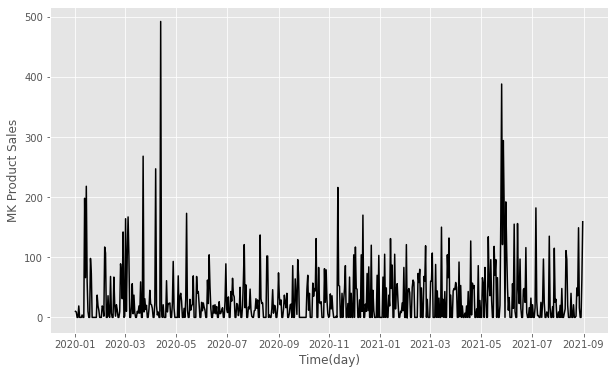

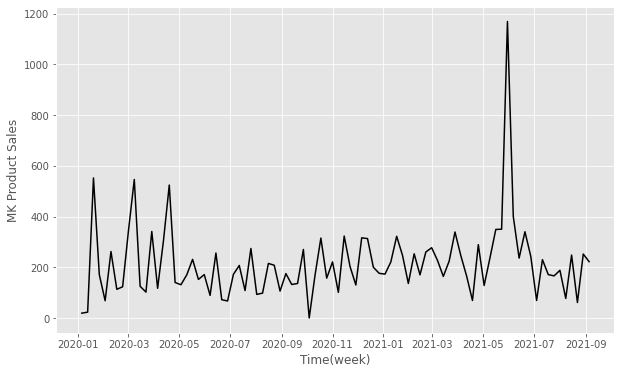

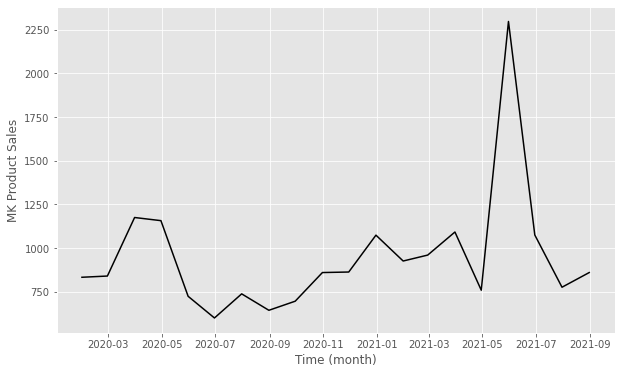

In [174]:
# Graph by day, week, month
# 일별 그래프
dataset['day'] = dataset.index.day
dataset_by_day = dataset.resample('D').sum()
timeseries(dataset_by_day.index, dataset_by_day['counts'], 
           'Time(day)')

# 주별 그래프
dataset['week'] = dataset.index.week
dataset_by_week= dataset.resample('W').sum()
timeseries(dataset_by_week.index, dataset_by_week['counts'], 
           'Time(week)')

# 월별 그래프
dataset['month'] = dataset.index.month
dataset_by_year = dataset.resample('M').sum()
timeseries(dataset_by_year.index, dataset_by_year['counts'], 
           'Time (month)')

# 년도별 그래프
# dataset['year'] = dataset.index.year
# dataset_by_year = dataset.resample('Y').sum()
# timeseries(dataset_by_year.index, dataset_by_year['counts'], 
#            'Time (Year)')

<Figure size 1296x576 with 0 Axes>

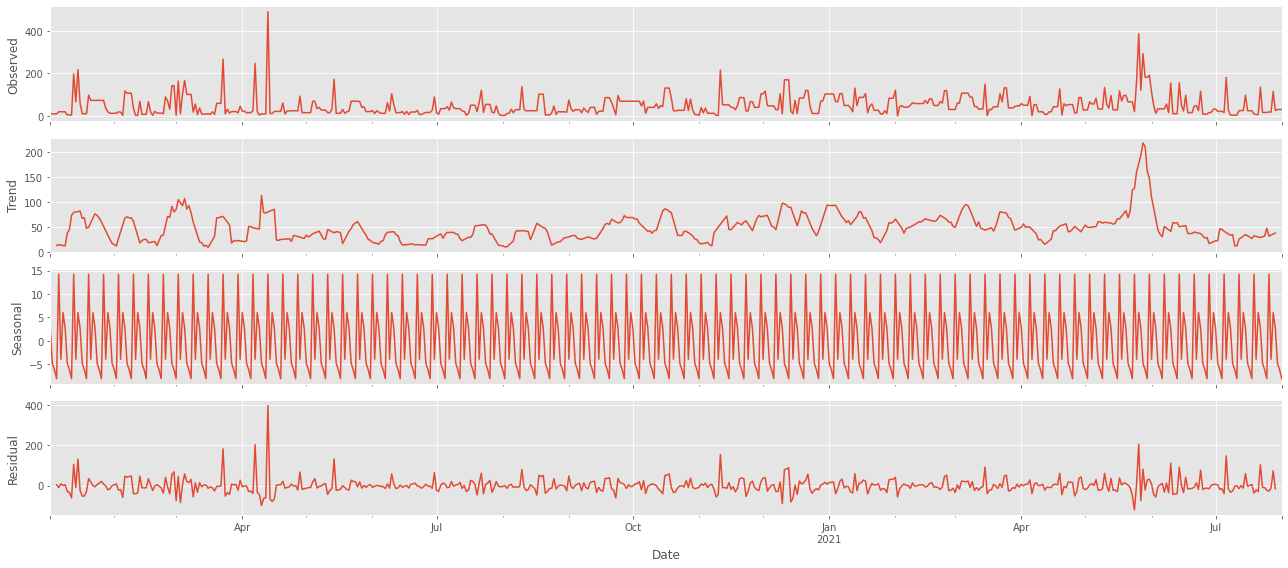

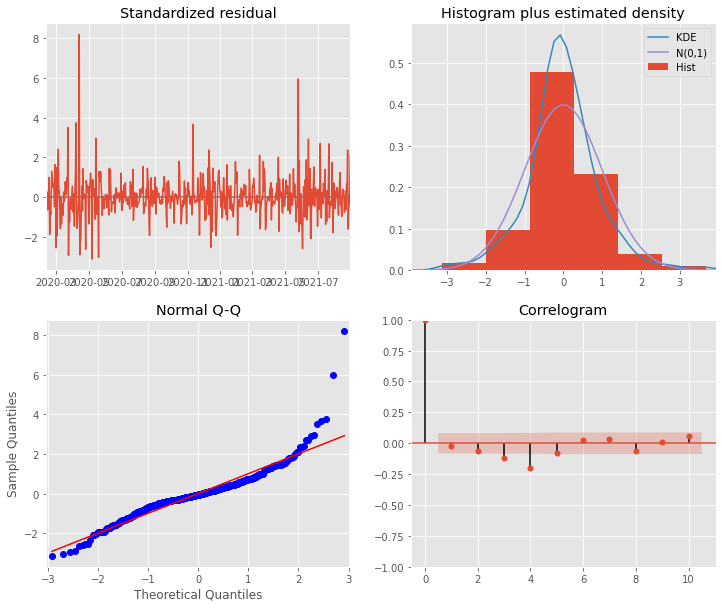

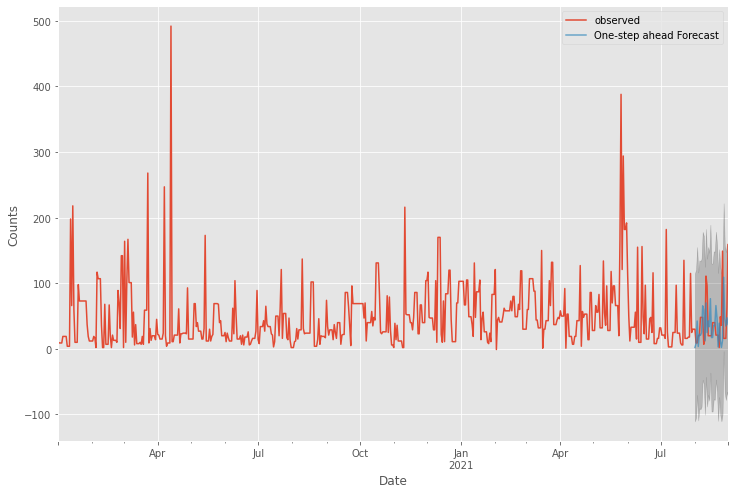

RMSE: 34.03474688049043


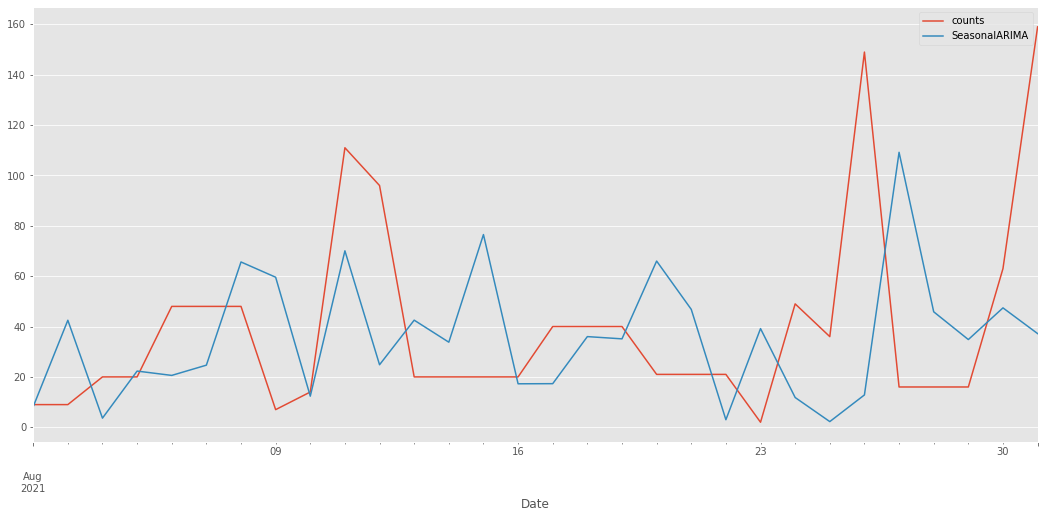

In [175]:
# 2) ARIMA
# 그래프에 대한 관측치, 추세, 계절성, 잔차 표시
SARIMADay = sm.tsa.statespace.SARIMAX(
    ARIMA_day,
     order=(3, 1, 0),
      seasonal_order=(2, 1, 0, 12),
      enforce_stationarity=False,
      enforce_invertibility=False
      )

plt.rcParams['figure.figsize'] = (18, 8)

result = sm.tsa.seasonal_decompose(trainA_data, model='additive')

fig = plt.figure()
fig = result.plot()

SARIMA_results_day = SARIMADay.fit()

SARIMA_results_day.plot_diagnostics(figsize=(12, 10))
plt.show()

## 

pred = SARIMA_results_day.get_prediction(
    start=pd.to_datetime('2021-08-01'),
    dynamic=False
)
pred_ci = pred.conf_int()

# 관측 데이터  2020년 부터 끝까지
ax = counts_Arima['counts']['2020': ].plot( label='observed', figsize=(12, 8) )

# 예측
pred.predicted_mean.plot(
    ax=ax,
    label='One-step ahead Forecast',
    alpha=.7
)

ax.fill_between(
    pred_ci.index,
    pred_ci['lower counts'],
    pred_ci['upper counts'],
    color='k',
    alpha=.2
)

ax.set_xlabel('Date')
ax.set_ylabel('Counts')
plt.legend(loc=1)

plt.show()

# 12개월 데이터로 예측 
# TODO : SARIMA_results_day의 companysum과 companytest로 나누어 실데이터 가데이터 나누기
SARIMA_predict_day_1 = SARIMA_results_day.predict()

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
testA_data_final['SeasonalARIMA'] = SARIMA_predict_day_1

# test 데이터와 예측 결과치를 비교
testA_data_final[1:].plot()

# RMSE를 살펴 봄
RMSE_Day_Seasonal_ARIMA  = np.mean(np.sqrt((testA_data_final['SeasonalARIMA'] - testA_data_final['counts']) ** 2)) 
print("RMSE:",RMSE_Day_Seasonal_ARIMA)

In [176]:
Xgboost_Data['counts']=Xgboost_Data['counts'].astype(int)
Xgboost_Data = Xgboost_Data.groupby(['Ustore','store', 'item'])['counts'].resample('M').sum()
# Xgboost_Data = Xgboost_Data.groupby(['Ustore','store', 'item'])['counts'].resample('M').sum()
Xgboost_Data = Xgboost_Data.reset_index()
Xgboost_Data = Xgboost_Data.set_index('Date')
Xgboost_Data = Xgboost_Data.sort_values(by=['Date'])

Xgboost_Data['month'] = Xgboost_Data.index.month
Xgboost_Data['year'] = Xgboost_Data.index.year
Xgboost_Data['dayofweek'] = Xgboost_Data.index.dayofweek
Xgboost_Data['day'] = Xgboost_Data.index.day

[06:18:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


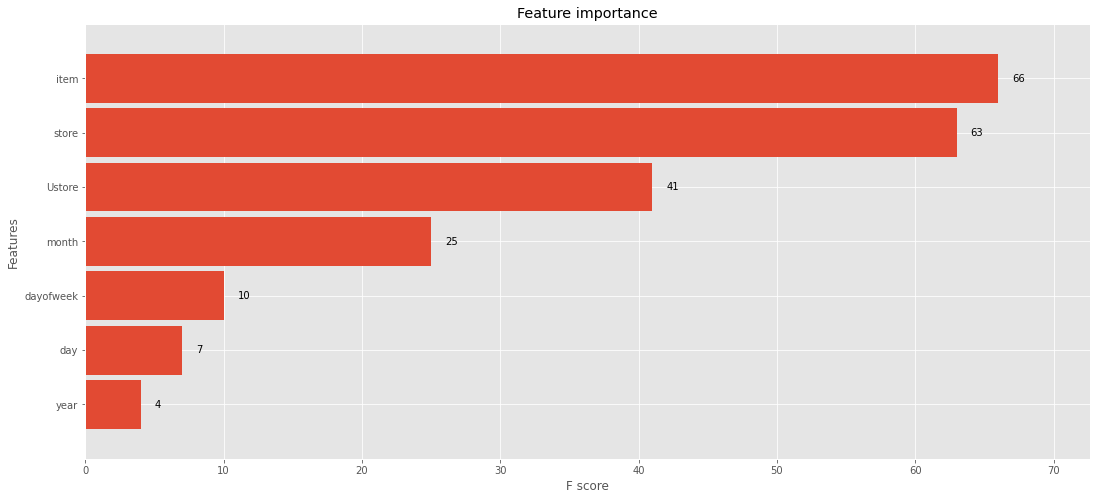

In [177]:
# Split train data and test data
# train_size = int(len(Xgboost)*0.9)

# train_data = Xgboost[:train_size]
# test_data = Xgboost[train_size:]

# Xgboost, RNN(LSTM), BILSTM, GRU
# scaler = MinMaxScaler().fit(train_data)
# train_scaled = scaler.transform(train_data)
# test_scaled = scaler.transform(test_data)

# Split train data and test data
train_size = "2021-08-01"

train_data = Xgboost_Data.loc[:train_size]
test_data = Xgboost_Data.loc[train_size:]

# Xgboost
# y값은 판매량, 나머지 항목들로 x값을 구성
Xgboost_train_y = train_data.loc[:,'counts']
Xgboost_train_x = train_data.drop('counts', axis=1)
Xgboost_test_y = test_data.loc[:,'counts']
Xgboost_test_x = test_data.drop('counts', axis=1)

y_train2 = Xgboost_train_y
y_test2 = Xgboost_test_y

X_train2 = np.array(Xgboost_train_x).reshape(Xgboost_train_x.shape[0], Xgboost_train_x.shape[1], 1)
X_test2 = np.array(Xgboost_test_x).reshape(Xgboost_test_x.shape[0], Xgboost_test_x.shape[1], 1)

# Xgboost_val_x, Xgboost_test_x, Xgboost_val_y, Xgboost_test_y = train_test_split(Xgboost_test_x, Xgboost_test_y, test_size=0.5, random_state=1, shuffle=False)

Xgboost_test_orig = test_data.loc[:, ['Ustore', 'store', 'item', 'counts']]

XG_model_month = xgb.XGBRegressor(n_estimators=400)
XG_model_month.fit(Xgboost_train_x, Xgboost_train_y, eval_set=[(Xgboost_test_x, Xgboost_test_y)], early_stopping_rounds=10,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

# 테스트 데이터 중 특정 store/item 데이터를 추출
Xgboost_Choice = Xgboost_test_x

Xgboost_result = XG_model_month.predict(Xgboost_Choice)

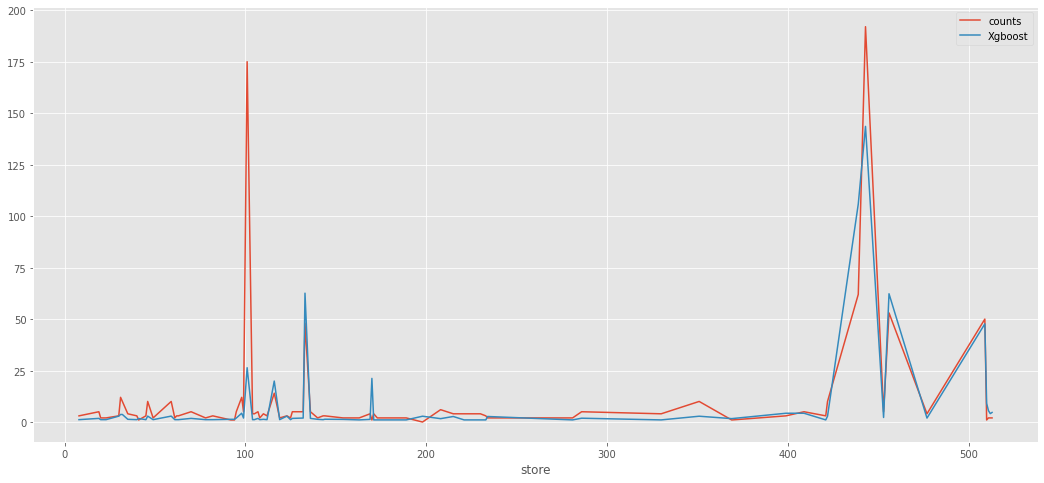

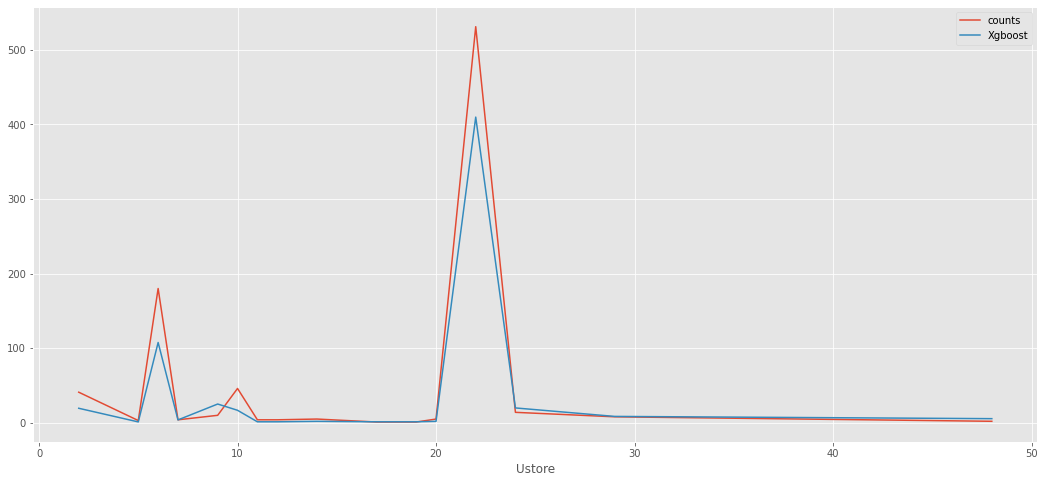

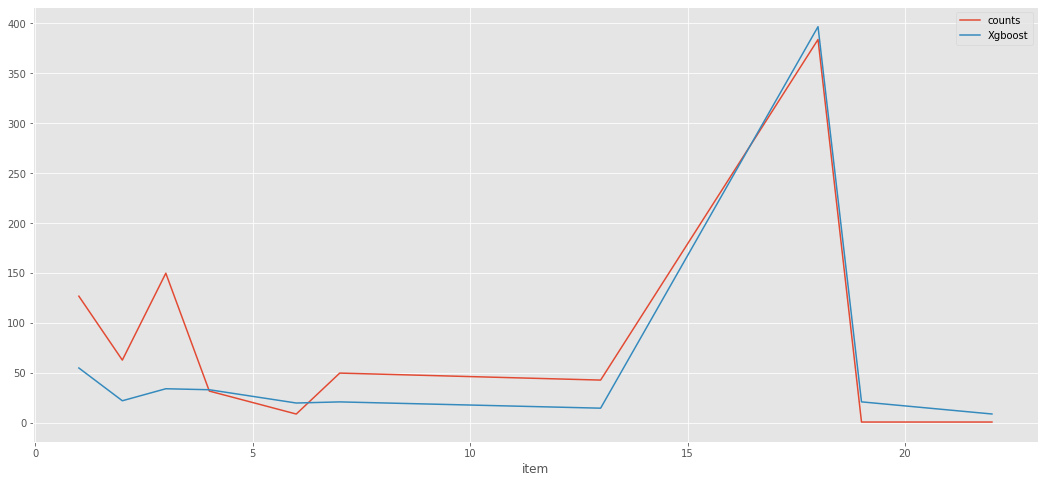

In [178]:
# 3) Xgboost

# 테스트 데이터 중 특정 store/item 데이터를 추출
Xgboost_Choice = Xgboost_test_x
Xgboost = XG_model_month.predict(Xgboost_Choice)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result1=pd.concat([Xgboost_test_orig.reset_index(), pd.DataFrame(Xgboost, columns=['Xgboost'])], axis=1, ignore_index=False)
result1 = result1.groupby(['store']).sum()
result1 = result1.loc[:, ['counts', 'Xgboost']]
result1.plot()

result2=pd.concat([Xgboost_test_orig.reset_index(), pd.DataFrame(Xgboost, columns=['Xgboost'])], axis=1, ignore_index=False)
result2 = result2.groupby(['Ustore']).sum()
result2 = result2.loc[:, ['counts', 'Xgboost']]
result2.plot()

result3=pd.concat([Xgboost_test_orig.reset_index(), pd.DataFrame(Xgboost, columns=['Xgboost'])], axis=1, ignore_index=False)
result3 = result3.groupby(['item']).sum()
result3 = result3.loc[:, ['counts', 'Xgboost']]
result3.plot()

X_train.shape:  (516, 31, 1)
y_train.shape:  (516, 1)
X_test.shape:  (30, 31, 1)
y_test.shape:  (30, 1)
Epoch 1/100
42/42 [==============================] - 4s 38ms/step - loss: 0.0090 - accuracy: 0.0024 - val_loss: 0.0126 - val_accuracy: 0.0000e+00
Epoch 2/100
42/42 [==============================] - 1s 26ms/step - loss: 0.0083 - accuracy: 0.0024 - val_loss: 0.0128 - val_accuracy: 0.0000e+00
Epoch 3/100
42/42 [==============================] - 1s 26ms/step - loss: 0.0082 - accuracy: 0.0024 - val_loss: 0.0125 - val_accuracy: 0.0000e+00
Epoch 4/100
42/42 [==============================] - 1s 26ms/step - loss: 0.0083 - accuracy: 0.0024 - val_loss: 0.0127 - val_accuracy: 0.0000e+00
Epoch 5/100
42/42 [==============================] - 1s 26ms/step - loss: 0.0083 - accuracy: 0.0024 - val_loss: 0.0125 - val_accuracy: 0.0000e+00
Epoch 6/100
42/42 [==============================] - 1s 25ms/step - loss: 0.0082 - accuracy: 0.0024 - val_loss: 0.0126 - val_accuracy: 0.0000e+00
Epoch 7/100
42/42 [=

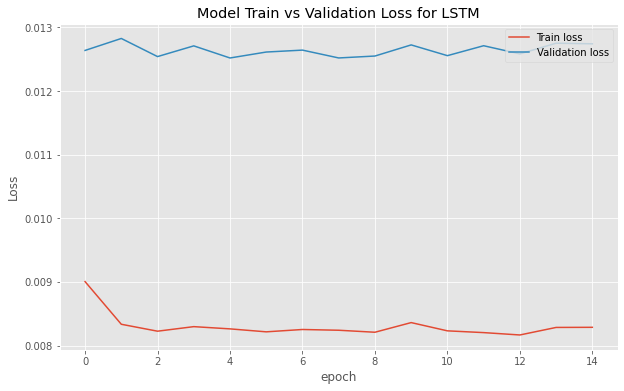

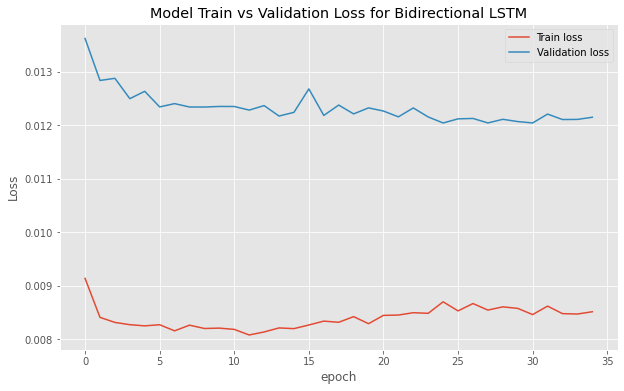

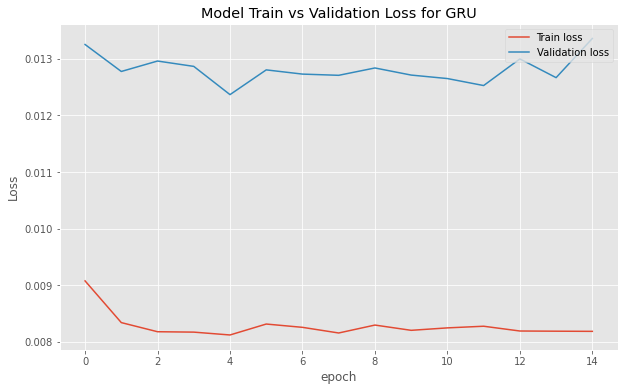

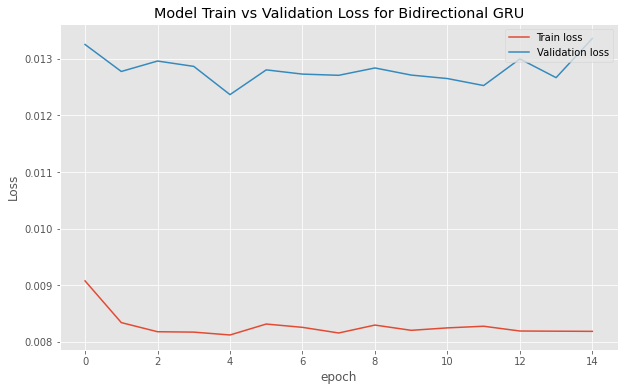

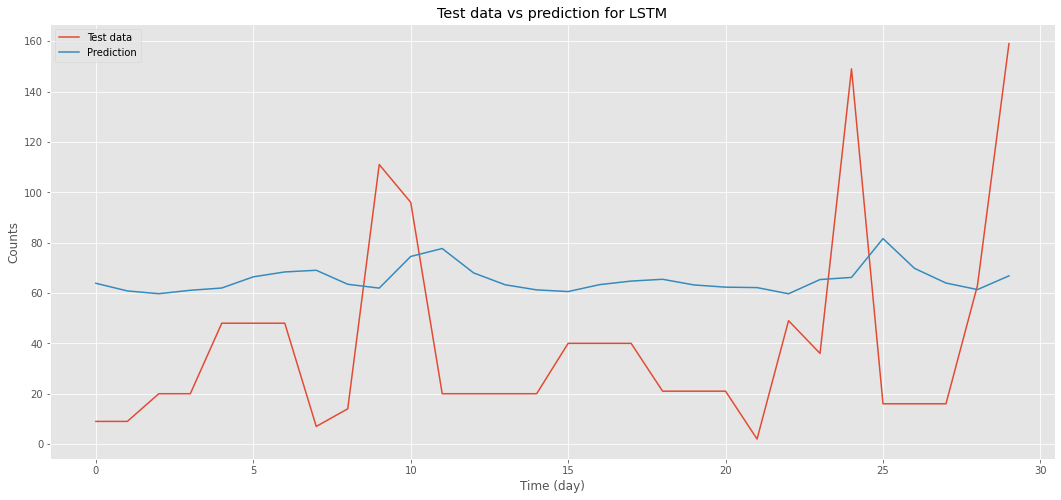

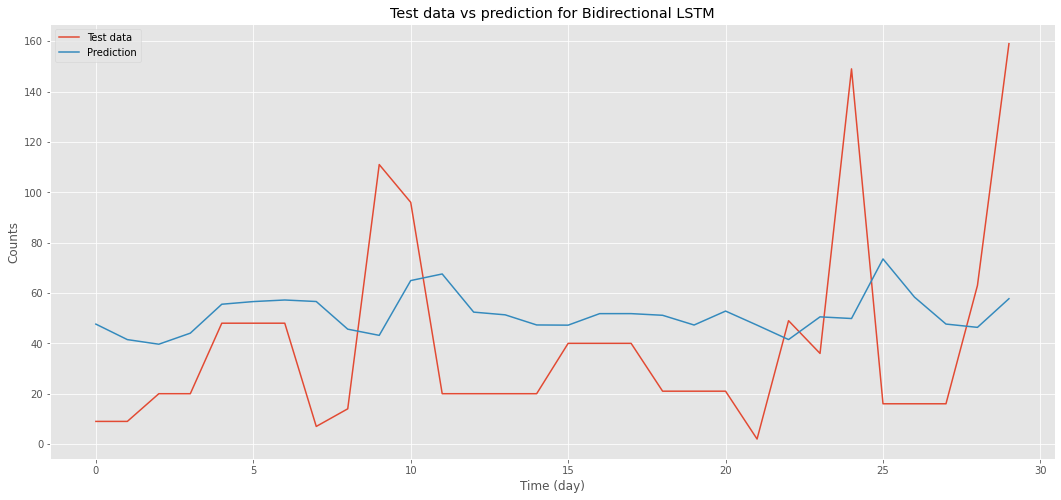

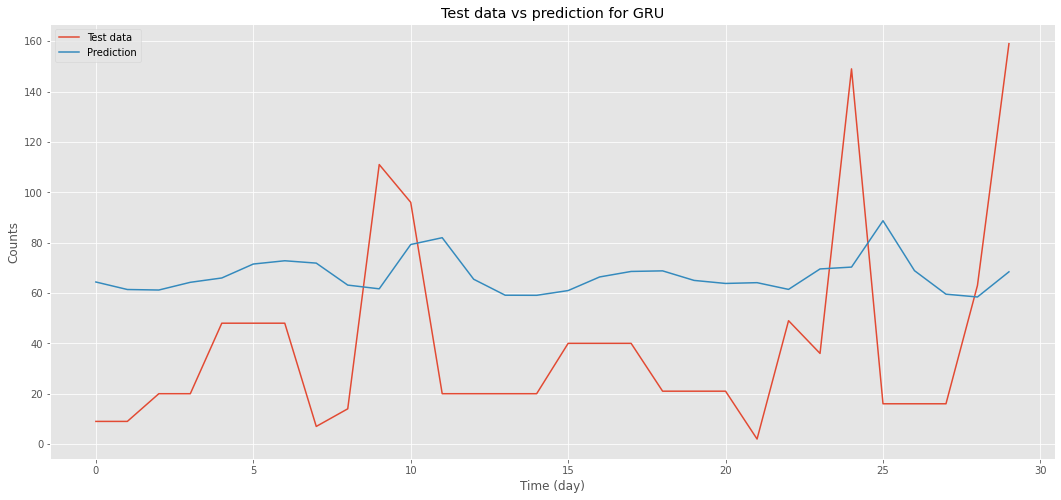

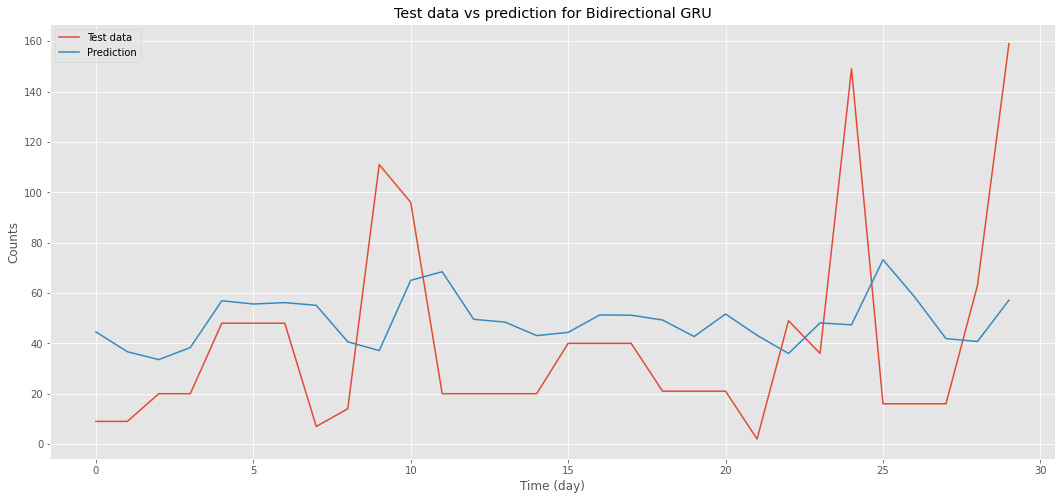

In [8]:
trainA_size = int(len(df2)*0.9)
trainA_data = df2.iloc[:trainA_size]
testA_data = df2.iloc[trainA_size:]

scaler = MinMaxScaler().fit(trainA_data)
train_scaled = scaler.transform(trainA_data)
test_scaled = scaler.transform(testA_data)

# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 31

X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)


# Create LSTM model
def create_lstm(units):
    # input shape에 전처리된 train_x의 형태를 넣는다
    # 20%로 Drop-out 했다
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units = units,input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(keras.layers.Dense(units=units))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Create BiGRU model
def create_bigru(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
        GRU (units = units, return_sequences = True), 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model


def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 10, shuffle = False, 
                        callbacks = [early_stop])
    return history


def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')


# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(18, 8))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Counts')

model_lstm = create_lstm(128)
model_bilstm = create_bilstm(128)
model_gru = create_gru(128)
model_bigru = create_bilstm(128)

history_lstm = fit_model(model_lstm)
history_bilstm = fit_model(model_bilstm)
history_gru = fit_model(model_gru)
history_bigru = fit_model(model_bigru)

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

plot_loss (history_lstm, 'LSTM')
plot_loss (history_bilstm, 'Bidirectional LSTM')
plot_loss (history_gru, 'GRU')
plot_loss (history_gru, 'Bidirectional GRU')

prediction_lstm = prediction(model_lstm)
prediction_bilstm = prediction(model_bilstm)
prediction_gru = prediction(model_gru)
prediction_bigru = prediction(model_bigru)

plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bigru, 'Bidirectional GRU', y_test)

X_train.shape:  (6007, 7, 1)
y_train.shape:  (6007,)
X_test.shape:  (93, 7, 1)
y_test.shape:  (93,)
Epoch 1/100
541/541 [==============================] - 7s 10ms/step - loss: 50.4298 - accuracy: 0.0847 - val_loss: 779.0639 - val_accuracy: 0.0899
Epoch 2/100
541/541 [==============================] - 5s 8ms/step - loss: 48.5653 - accuracy: 0.0914 - val_loss: 740.6184 - val_accuracy: 0.0915
Epoch 3/100
541/541 [==============================] - 5s 8ms/step - loss: 47.4310 - accuracy: 0.1099 - val_loss: 737.7117 - val_accuracy: 0.0899
Epoch 4/100
541/541 [==============================] - 4s 8ms/step - loss: 46.9844 - accuracy: 0.1006 - val_loss: 725.1129 - val_accuracy: 0.0899
Epoch 5/100
541/541 [==============================] - 5s 8ms/step - loss: 46.2622 - accuracy: 0.0936 - val_loss: 736.5737 - val_accuracy: 0.0899
Epoch 6/100
541/541 [==============================] - 5s 8ms/step - loss: 46.6956 - accuracy: 0.0979 - val_loss: 716.6895 - val_accuracy: 0.0899
Epoch 7/100
541/541 [==

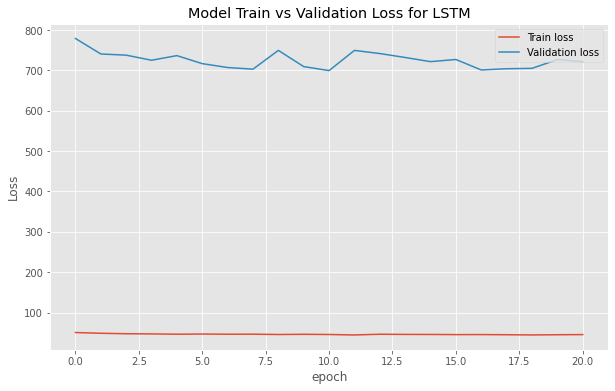

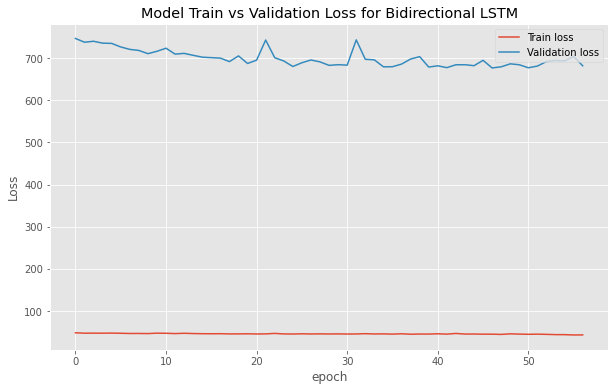

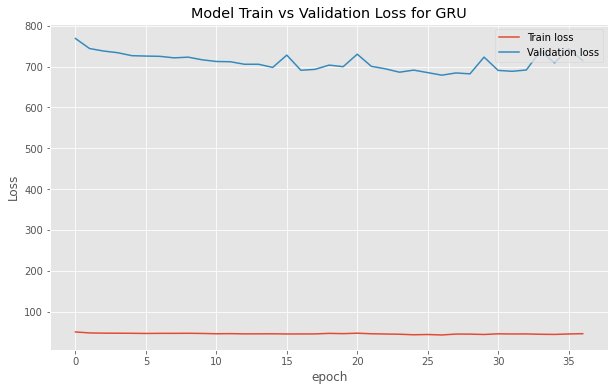

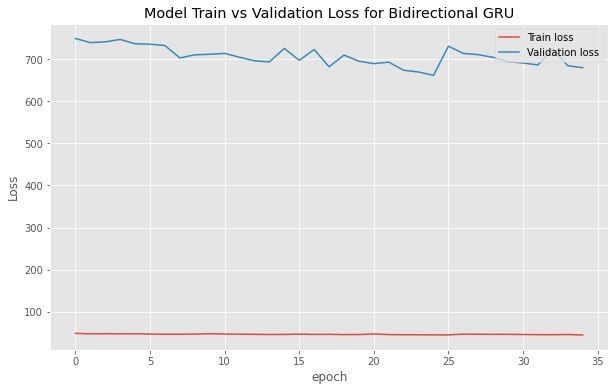

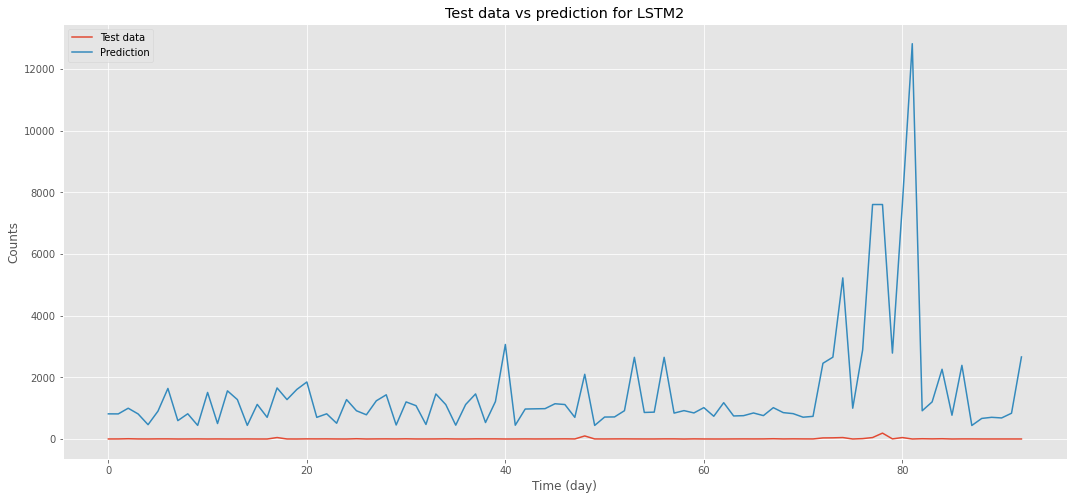

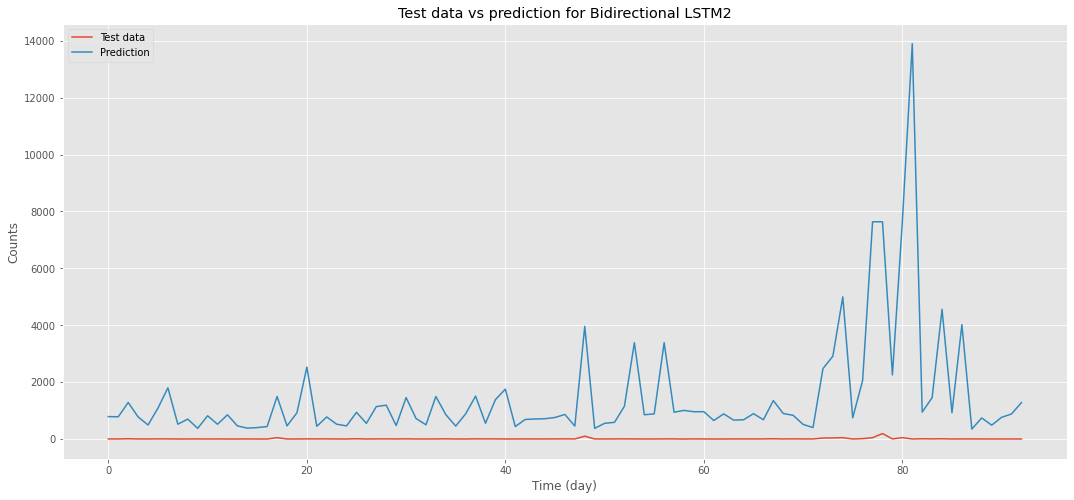

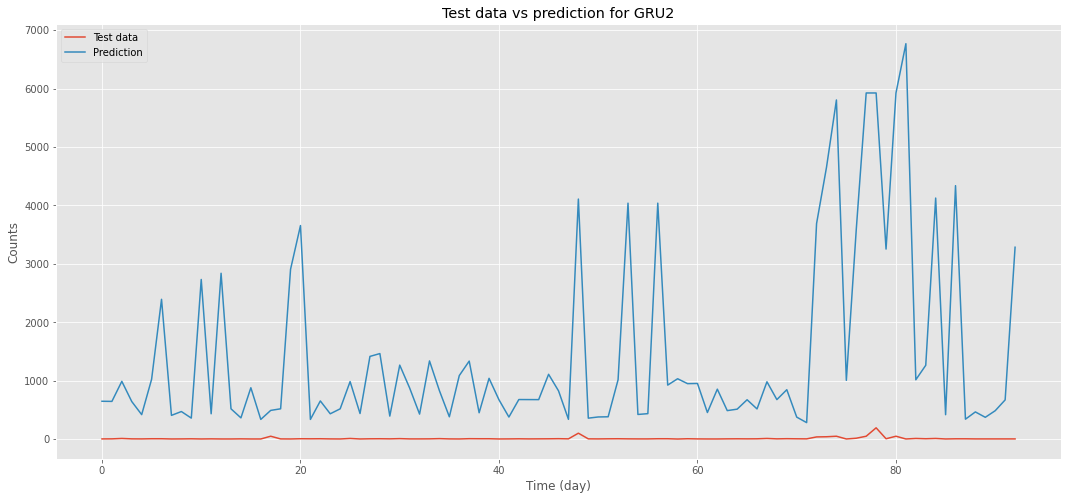

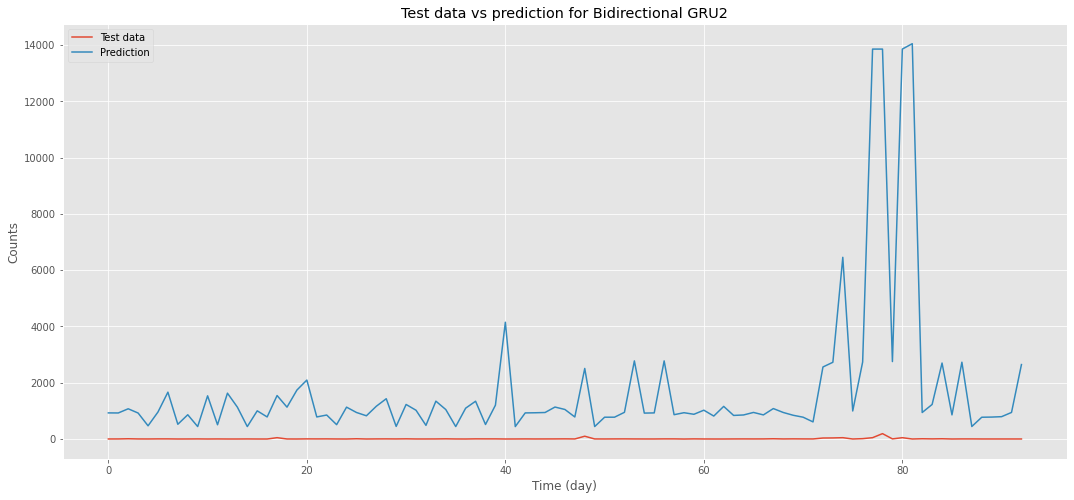

In [9]:
# Print data shape
print('X_train.shape: ', X_train2.shape)
print('y_train.shape: ', y_train2.shape)
print('X_test.shape: ', X_test2.shape) 
print('y_test.shape: ', y_test2.shape)



# Create LSTM model
def create_lstm2(units):
    # input shape에 전처리된 train_x의 형태를 넣는다
    # 20%로 Drop-out 했다
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units = units,input_shape=(X_train2.shape[1], X_train2.shape[2])))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(keras.layers.Dense(units=units))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Create BiLSTM model
def create_bilstm2(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train2.shape[1], X_train2.shape[2])))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Create GRU model
def create_gru2(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train2.shape[1], X_train2.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Create BiGRU model
def create_bigru2(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
        GRU (units = units, return_sequences = True), 
    input_shape = [X_train2.shape[1], X_train2.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

def fit_model2(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train2, y_train2, epochs = 100,  
                        validation_split = 0.1,
                        batch_size = 10, shuffle = False, 
                        callbacks = [early_stop])
    return history


def plot_loss2(history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')


# Make prediction
def prediction2(model):
    prediction = model.predict(X_test2)
    prediction = scaler.inverse_transform(prediction)
    return prediction

# Plot test data vs prediction
def plot_future2(prediction, model_name, y_test):
    plt.figure(figsize=(18, 8))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Counts')

model_lstm2 = create_lstm2(128)
model_bilstm2 = create_bilstm2(128)
model_gru2 = create_gru2(128)
model_bigru2 = create_bilstm2(128)

history_lstm2 = fit_model2(model_lstm2)
history_bilstm2 = fit_model2(model_bilstm2)
history_gru2 = fit_model2(model_gru2)
history_bigru2 = fit_model2(model_bigru2)


plot_loss2(history_lstm2, 'LSTM')
plot_loss2(history_bilstm2, 'Bidirectional LSTM')
plot_loss2(history_gru2, 'GRU')
plot_loss2(history_bigru2, 'Bidirectional GRU')

prediction_lstm2 = prediction2(model_lstm2)
prediction_bilstm2 = prediction2(model_bilstm2)
prediction_gru2 = prediction2(model_gru2)
prediction_bigru2 = prediction2(model_bigru2)

plot_future2(prediction_lstm2, 'LSTM2', y_test2)
plot_future2(prediction_bilstm2, 'Bidirectional LSTM2', y_test2)
plot_future2(prediction_gru2, 'GRU2', y_test2)
plot_future2(prediction_bigru2, 'Bidirectional GRU2', y_test2)

In [172]:
# plot_future(Xgboost, 'Xgboost', Xgboost_test_y)
result_xgboost=pd.concat([Xgboost_test_orig.reset_index(), pd.DataFrame(Xgboost, columns=['Xgboost'])], axis=1, ignore_index=False)
result_xgboost = result_xgboost.groupby(['Date']).sum()
result_xgboost = result_xgboost.loc[:, ['counts', 'Xgboost']]
result_xgboost

,counts,Xgboost
Date,,
2021-08-01,0,5.15
2021-08-02,9,21.21
2021-08-03,0,25.25
2021-08-04,20,24.95
2021-08-05,0,25.72
...,...,...
2021-08-27,16,3.73
2021-08-28,0,1.87
2021-08-29,0,1.87


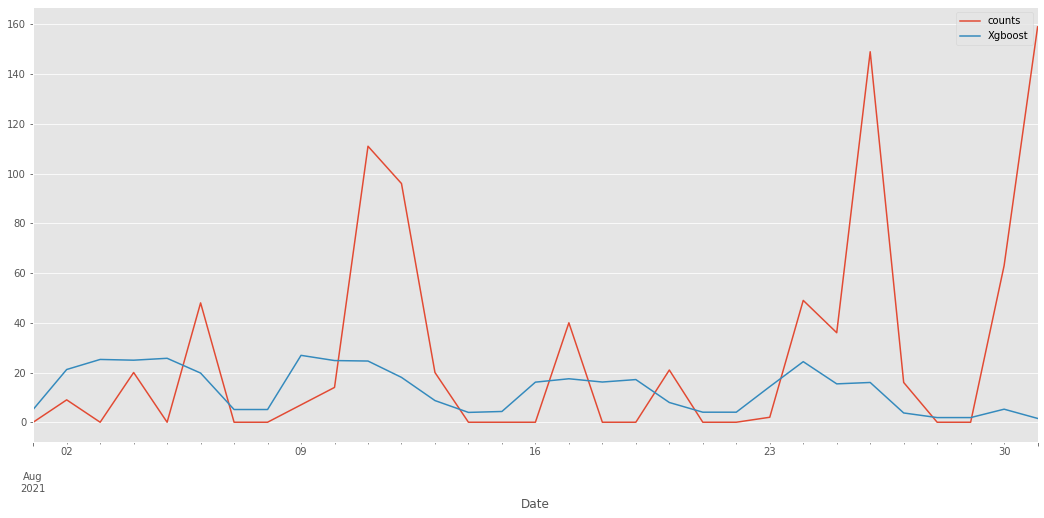

In [171]:
# result_xgboost[1:].plot()
result_xgboost.plot()

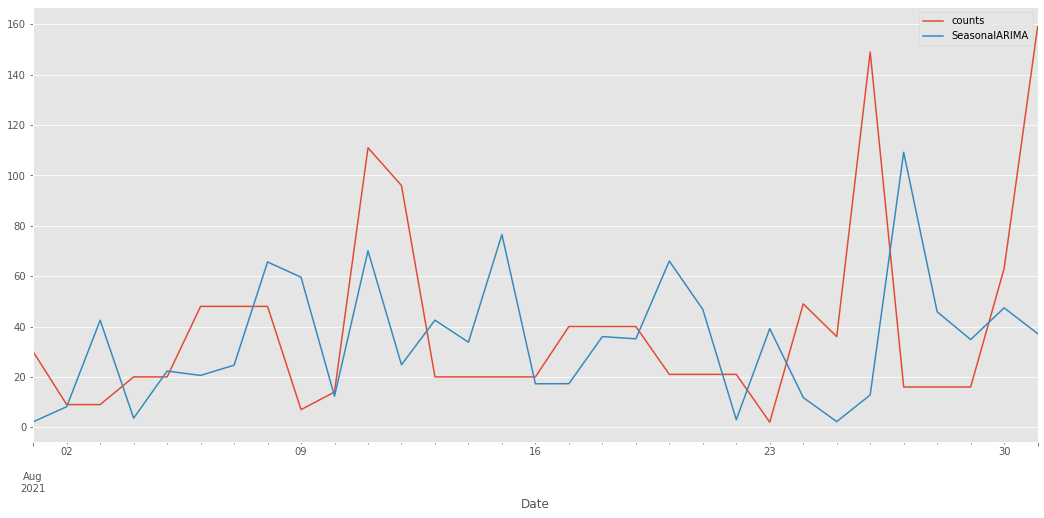

In [169]:
# 12개월 데이터로 예측 
# TODO : SARIMA_results_day의 companysum과 companytest로 나누어 실데이터 가데이터 나누기
SARIMA_predict_day_1 = SARIMA_results_day.predict()

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
testA_data_final['SeasonalARIMA'] = SARIMA_predict_day_1

# test[1:] 데이터와 예측 결과치를 비교
testA_data_final.plot()

In [179]:
def evaluate_prediction(predictions, actual, model_name):
    print(model_name + ':')
    print('r2_score: {:.4f}'.format(r2_score(actual, predictions)))
    print('Mean Absolute Error: {:.4f}'.format(mean_absolute_error(actual, predictions)))
    print('MSE: {:.4f}'.format(mean_squared_error(actual, predictions)))
    print('Root Mean Square Error: {:.4f}'.format(np.sqrt(mean_absolute_error(actual, predictions))))
    print('RMSLE: {:.4f}'.format(np.sqrt(mean_squared_error(actual, predictions))))
    print('')

# Main Graph - Validation
# plot_future(prediction_lstm, 'LSTM', y_test)
# plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)
# plot_future(prediction_gru, 'GRU', y_test)
# plot_future(prediction_bigru, 'Bidirectional GRU', y_test)
# testA_data_final[1:].plot()

# RMSE_Day_Seasonal_ARIMA  = np.mean(np.sqrt((testA_data_final['SeasonalARIMA'] - testA_data_final['counts']) ** 2))
# MAE_Day_Seasonal_ARIMA  = np.abs(RMSE_Day_Seasonal_ARIMA).mean()
# print("ARIMA: \nMean Absolute Square Error: {:.4f}".format(MAE_Day_Seasonal_ARIMA))
# print("Root Mean Square Error: {:.4f}".format(RMSE_Day_Seasonal_ARIMA))
# print('')

evaluate_prediction(testA_data_final['SeasonalARIMA'], testA_data_final['counts'], 'ARIMA')
evaluate_prediction(Xgboost, Xgboost_test_y, 'XGboost')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bigru, y_test, 'Bidirectiona GRU')

evaluate_prediction(prediction_lstm2, y_test2, 'LSTM')
evaluate_prediction(prediction_bilstm2, y_test2, 'Bidirectiona LSTM')
evaluate_prediction(prediction_gru2, y_test2, 'GRU')
evaluate_prediction(prediction_bigru2, y_test2, 'Bidirectiona GRU')

ARIMA:
r2_score: -0.4999
Mean Absolute Error: 34.0347
MSE: 2200.2558
Root Mean Square Error: 5.8339
RMSLE: 46.9069

XGboost:
r2_score: 0.7031
Mean Absolute Error: 5.0778
MSE: 167.8190
Root Mean Square Error: 2.2534
RMSLE: 12.9545

LSTM:
r2_score: -0.4270
Mean Absolute Error: 41.7689
MSE: 2158.4964
Root Mean Square Error: 6.4629
RMSLE: 46.4596

Bidirectiona LSTM:
r2_score: -0.0911
Mean Absolute Error: 33.1258
MSE: 1650.4485
Root Mean Square Error: 5.7555
RMSLE: 40.6257

GRU:
r2_score: -0.4716
Mean Absolute Error: 42.8863
MSE: 2226.0485
Root Mean Square Error: 6.5488
RMSLE: 47.1810

Bidirectiona GRU:
r2_score: -0.0622
Mean Absolute Error: 31.7991
MSE: 1606.6554
Root Mean Square Error: 5.6391
RMSLE: 40.0831

LSTM:
r2_score: -9656.5682
Mean Absolute Error: 1500.9391
MSE: 5458635.3158
Root Mean Square Error: 38.7420
RMSLE: 2336.3723

Bidirectiona LSTM:
r2_score: -10509.3746
Mean Absolute Error: 1460.6070
MSE: 5940657.1623
Root Mean Square Error: 38.2179
RMSLE: 2437.3463

GRU:
r2_score: -793

In [ ]:
from tensorflow.keras import load_model
model.save('mnist_mlp_model.h5')